# Analysis

In [2]:
from tqdm import tqdm
import pandas as pd

flu_rate = pd.read_csv('./data/170102_210531_influenza.csv')
word_trends = pd.read_csv('./data/독감+증상_word_trends.csv')

In [3]:
def cross_corr(x, y, max_lag=0):
    '''
    Args:
        x (pandas.Series): fixed data
        y (pandas.Series): data to be shifted
    
    Returns:
        corr (pandas.Series): {0: XX.XX, 1: XX.XX, ..., max_lag: XX.XX}
    '''
    corr = {}
    for lag in range(max_lag+1):
        corr[lag] = x.corr(y.shift(lag))
    return pd.Series(corr)


In [27]:
word_trends_with_lag = {word: cross_corr(flu_rate['ratio'], word_trends[word], max_lag=12)
                         for word in tqdm(word_trends.columns[1:])}

100%|██████████| 1000/1000 [00:05<00:00, 194.77it/s]


In [30]:
corr_topn = []
for word, corr in word_trends_with_lag.items():
    lag = corr.argmax()
    max_corr = corr[lag]
    corr_topn.append((word, max_corr, lag))

corr_topn.sort(key=(lambda x: x[1]), reverse=True)

In [4]:
tmp = [5.61697     ,
2.84308     ,
1.65605     ,
1.06527     ,
0.97013     ,
0.8289       ,
0.65            ,
0.55869     ,
0.52322     ,
0.57457     ,
0.83569     ,
1.1787       ,
1.18231     ,
1.43675     ,
1.23246     ,
0.95437     ,
0.75062     ,
0.5149       ,
0.42841     ,
0.41822     ,
0.36272     ,
0.36381     ,
0.32122     ,
0.26593     ,
0.21568     ,
0.16871     ,
0.17013     ,
0.17013     ,
0.20561     ,
0.16313     ,
0.15294     ,
0.17626     ,
0.19192     ,
0.30885     ,
0.4052       ,
0.56778     ,
0.64091     ,
0.70146     ,
0.79375     ,
0.48085     ,
1.09987     ,
1.22096     ,
1.13502     ,
1.1487       ,
0.9975       ,
1.00572     ,
1.0875       ,
1.74046     ,
2.89924     ,
3.98598     ,
7.22386     ,
10.17194   ,
12.62679   ,
11.04595   ,
6.55973     ,
4.13094     ,
2.75648     ,
2.14621     ,
1.42362     ,
1.24165     ,
0.8728       ,
0.72544     ,
0.71328     ,
0.70715     ,
0.64267     ,
0.60489     ,
0.61508     ,
0.61694     ,
0.57172     ,
0.5449       ,
0.5045       ,
0.45348     ,
0.45085     ,
0.3937       ,
0.30983     ,
0.30983     ,
0.27776     ,
0.23878     ,
0.20013     ,
0.21141     ,
0.21196     ,
0.15502     ,
0.16948     ,
0.15601     ,
0.16904     ,
0.20725     ,
0.29571     ,
0.63205     ,
0.91835     ,
0.76792     ,
0.85813     ,
2.70414     ,
1.73061     ,
1.622          ,
1.54142     ,
1.64861     ,
1.96436     ,
2.24365     ,
2.81877     ,
4.30699     ,
6.57101     ,
8.48194     ,
13.03823   ,
10.5282     ,
5.45471     ,
3.36915     ,
1.88859     ,
1.85137     ,
1.48186     ,
0.91342     ,
0.83919     ,
0.78062     ,
0.73792     ,
0.74055     ,
1.31764     ,
2.57867     ,
3.66475     ,
4.08276     ,
4.84247     ,
4.65898     ,
3.29415     ,
2.7729       ,
1.46303     ,
1.07108     ,
0.76649     ,
0.6119       ,
0.48063     ,
0.50034     ,
0.38286     ,
0.31739     ,
0.28816     ,
0.30108     ,
0.27283     ,
0.2217       ,
0.20911     ,
0.21261     ,
0.22597     ,
0.27688     ,
0.36129     ,
0.45742     ,
0.51457     ,
1.11093     ,
1.24997     ,
1.17049     ,
1.53244     ,
2.09267     ,
2.23008     ,
2.19997     ,
2.02578     ,
2.46667     ,
2.31876     ,
2.24518     ,
2.48517     ,
3.38535     ,
4.54183     ,
5.50595     ,
6.48912     ,
6.65137     ,
4.96663     ,
4.366          ,
5.02652     ,
2.58469     ,
1.18844     ,
1.33461     ,
1.53091     ,
0.83547     ,
0.70792     ,
1.1706       ,
0.60708     ,
0.47428     ,
0.45698     ,
0.34334     ,
0.3695       ,
0.28794     ,
0.26922     ,
0.33699     ,
0.55486     ,
0.3833       ,
0.33567     ,
0.27644     ,
0.26046     ,
0.27633     ,
0.32921     ,
0.28641     ,
0.25936     ,
0.25225     ,
0.21042     ,
0.19006     ,
0.25706     ,
0.41242     ,
0.58136     ,
0.95973     ,
6.76885     ,
4.51074     ,
100.0          ,
5.79422     ,
8.30743     ,
6.42901     ,
34.00552   ,
5.01228     ,
1.67017     ,
1.17782     ,
0.96302     ,
0.86153     ,
0.77799     ,
0.78981     ,
0.73157     ,
0.57632     ,
0.48643     ,
0.38757     ,
0.37553     ,
0.31783     ,
0.29911     ,
0.27962     ,
0.22904     ,
0.26079     ,
0.24371     ,
0.27852     ,
0.2713       ,
0.26856     ,
0.24206     ,
0.26396     ,
0.27951     ,
0.26276     ,
0.29352     ,
0.24535     ,
0.27885     ,
0.26319     ,
0.24053     ,
0.26582     ,
0.26111     ,]

tmp = pd.Series(tmp)

<AxesSubplot:>

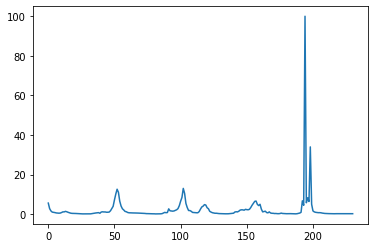

In [5]:
tmp.plot()

In [6]:
tmp.corr(flu_rate['ratio'])

0.21261542730699362

<AxesSubplot:>

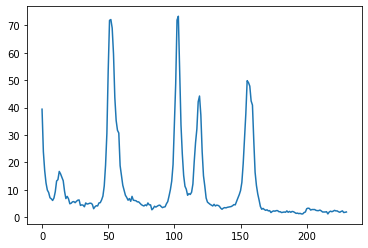

In [33]:
flu_rate['ratio'].plot()

<AxesSubplot:>

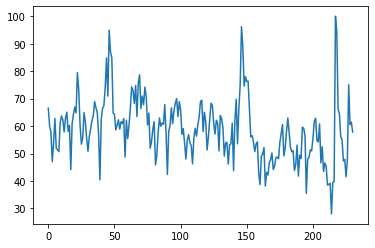

In [45]:
word_trends['항암제'].plot()

In [32]:
corr_topn[:50]

[('몸살', 0.6033543021231151, 0),
 ('축농증', 0.575092260282384, 1),
 ('기관지염', 0.5624696466654443, 1),
 ('수액', 0.5483436337963298, 1),
 ('코골이', 0.5405218251906332, 0),
 ('건조증', 0.5120483497405361, 4),
 ('췌장', 0.5081889226054346, 9),
 ('자궁암', 0.5075452575310677, 4),
 ('색맹', 0.5006879786671139, 9),
 ('부비강염', 0.48776843864631464, 1),
 ('늑막염', 0.47918694213132956, 0),
 ('비염', 0.4630464458911876, 12),
 ('항암제', 0.4594743557960533, 7),
 ('구감', 0.4580456088311772, 10),
 ('중이염', 0.44327185941238717, 2),
 ('콧물', 0.4390768340820629, 1),
 ('회충', 0.43634889480155997, 6),
 ('과음', 0.41805983187601703, 1),
 ('내시경', 0.41691317082463564, 4),
 ('간암', 0.4123141983034351, 9),
 ('고혈압', 0.4103273817083101, 5),
 ('프리온', 0.40675643473581163, 8),
 ('고통', 0.40617725015555556, 9),
 ('항경', 0.40457509965932853, 8),
 ('크룹', 0.4042398783440661, 5),
 ('앓', 0.40240762436717137, 1),
 ('독시사이클린', 0.3999556633090733, 10),
 ('구토', 0.39215045068818694, 0),
 ('프라이온', 0.3914204833175014, 9),
 ('귀울림', 0.38845437878300076, 7),
 ('폐암'

## Extract "flu-related" words

In [2]:
from gensim.models import KeyedVectors

kv_fname = 'kowiki-neg-300.kv'
w2v_kv = KeyedVectors.load(f'./models/{kv_fname}')

In [4]:
w2v_kv.most_similar_cosmul(positive=['독감', '증상'], topn=30)

[('질병', 0.6456781029701233),
 ('합병증', 0.6416015028953552),
 ('패혈증', 0.6396576166152954),
 ('피부병', 0.6389033198356628),
 ('황달', 0.637260377407074),
 ('매독', 0.6342878341674805),
 ('기관지염', 0.6325851678848267),
 ('폐렴', 0.6323192715644836),
 ('급성', 0.6281660795211792),
 ('복통', 0.6278930902481079),
 ('홍역', 0.6278191804885864),
 ('대상포진', 0.6273614764213562),
 ('뎅기열', 0.6261769533157349),
 ('천식', 0.6254749298095703),
 ('뇌염', 0.6234469413757324),
 ('무증상', 0.6224794387817383),
 ('관절통', 0.6186830997467041),
 ('골다공증', 0.6164602041244507),
 ('파킨슨병', 0.615439772605896),
 ('폐질환', 0.6129343509674072),
 ('신장염', 0.6128467917442322),
 ('말라리아', 0.612651526927948),
 ('발병', 0.6126167178153992),
 ('심근염', 0.6122466325759888),
 ('결핵', 0.6121384501457214),
 ('부작용', 0.6108651161193848),
 ('뇌전증', 0.6089601516723633),
 ('알츠하이머병', 0.6067097783088684),
 ('파상풍', 0.6065411567687988),
 ('가려움증', 0.6062012314796448)]

In [11]:
import urllib
import json
from tqdm import tqdm

client_id = 'B4Vmp4Wt5ECl_fNWgIXR'
client_secret = 'WnmtyQRoNa'
naver_trends_url = 'https://openapi.naver.com/v1/datalab/search'

flu_related_words = [w for w, _ in w2v_kv.most_similar_cosmul(positive=['독감', '증상'], topn=1000)]
word_trends = {}

for word in tqdm(flu_related_words):
    try:
        body = ('{"startDate\":"2017-01-02","endDate":"2021-06-06","timeUnit":"week",' 
                + '"keywordGroups":[{"groupName":"' + word + '","keywords":[\"' + word + '\"]}]}')
        request = urllib.request.Request(naver_trends_url)
        request.add_header("X-Naver-Client-Id", client_id)
        request.add_header("X-Naver-Client-Secret", client_secret)
        request.add_header("Content-Type","application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        if rescode==200:
            resbody = response.read()
            resbody = json.loads(resbody.decode('utf8'))
            word_trends[word] = resbody['results'][0]['data']
        else:
            print(f'request is failed for {word}, error code: {rescode}')
    except:
        print(f'request is failed for {word}, error code: {rescode}')
        continue

100%|██████████| 999/999 [01:32<00:00, 10.76it/s]


In [63]:
from datetime import datetime
import pandas as pd

word_trends_fz = {}
for word, data in word_trends.items():
    word_trends_fz[word] = []
    i = 0
    for date in pd.date_range('20170102', '20210531', freq='W-MON').strftime('%Y-%m-%d'):
        if len(data)==0:
            word_trends_fz[word].append({'period': date, 'ratio': 0.0})
        else:
            if data[i]['period'] == date:
                word_trends_fz[word].append({'period': date, 'ratio': data[i]['ratio']})
                if i+1 < len(data):
                    i += 1
            else:
                word_trends_fz[word].append({'period': date, 'ratio': 0.0})

In [66]:
word_trends_df = pd.DataFrame({word: [prdict['ratio'] for prdict in prlist] for word, prlist in word_trends_fz.items()})
word_trends_df.insert(0, 'period', pd.date_range('20170102', '20210531', freq='W-MON').strftime('%Y-%m-%d'))
word_trends_df.to_csv('./data/word_trends.csv', index=False)

In [68]:
word_trends_df = pd.read_csv('./data/word_trends.csv')
word_trends_df

,period,질병,합병증,패혈증,피부병,황달,매독,기관지염,폐렴,급성,...,성욕,뇌막,뇌일혈,에리트로포이에틴,원추각막,열대병,요법,마비저,손상,통풍
0,2017-01-02,34.47181,41.12814,0.50525,42.93985,9.26411,5.46836,64.21550,5.74694,24.46393,...,100.00000,23.92473,18.26252,5.33980,100.00000,15.32258,38.62068,0.0,38.85653,61.21533
1,2017-01-09,36.39417,37.18510,0.86922,42.97201,9.21393,5.98957,58.60113,4.81950,20.66276,...,96.28552,23.65591,14.33100,5.33980,96.13677,4.03225,57.93103,0.0,40.81524,4.68184
2,2017-01-16,31.46696,37.89704,0.60639,43.61531,22.23031,5.82590,51.64461,4.45071,25.43859,...,79.06976,23.38709,15.53582,5.33980,90.10702,15.32258,46.20689,0.0,38.16834,3.69813
3,2017-01-23,23.81485,31.98247,0.39328,42.87552,9.12975,4.99098,37.98676,3.79676,20.27290,...,73.02971,11.55913,11.73113,10.67961,85.82615,19.35483,42.75862,0.0,28.69242,3.34324
4,2017-01-30,30.64576,31.92771,0.43524,46.47796,9.25764,5.56968,41.55009,4.04877,36.15984,...,88.27519,26.61290,11.73113,9.22330,91.28164,17.74193,28.27586,0.0,34.88618,3.41878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2021-05-03,53.45278,64.62212,0.50041,28.43357,8.79144,6.01782,22.93950,2.76159,26.41325,...,48.38501,57.25806,15.53582,28.64077,19.05507,20.16129,48.27586,0.0,40.86818,3.84868
227,2021-05-10,77.92086,66.86746,0.48556,30.74943,8.92255,6.28087,26.28544,2.94768,32.84600,...,54.45736,69.62365,17.31135,13.10679,18.74184,16.93548,73.10344,0.0,49.33827,3.97368
228,2021-05-17,67.95446,58.37897,0.49975,29.81666,9.53606,6.11330,24.27221,2.78343,28.55750,...,49.61240,66.39784,17.81864,10.19417,16.83633,14.51612,81.37931,0.0,42.56220,4.43700
229,2021-05-24,74.80403,62.32201,0.59264,29.72016,9.69794,6.33640,24.95274,2.91114,33.43079,...,50.35529,69.35483,17.94546,21.84466,21.63925,34.67741,84.13793,0.0,44.73266,4.34107


## Make wor2vec

In [4]:
from gensim.models import Word2Vec

min_count = 5
window_size = 5
num_neg = 15
vector_size = 300

print('Making sentences as list...')
sents = []
corpus_fname = 'kowiki_corpus.txt'

with open(f'./data/{corpus_fname}', 'r', encoding='utf8') as fin:
    line = fin.readline()
    while line:
        words = line.split()
        sents.append(words)
        line = fin.readline()

print('Making word vectors...')
w2v_model = Word2Vec(sents, vector_size=vector_size, min_count=min_count, negative=num_neg, window=window_size)

w2v_model.save('./models/kowiki-neg-300.bin')

Making sentences as list...
Making word vectors...


In [13]:
w2v_model.wv.most_similar('독감')

[('인플루엔자', 0.7366062998771667),
 ('홍역', 0.6661979556083679),
 ('콜레라', 0.652269721031189),
 ('출혈열', 0.648910641670227),
 ('유행병', 0.6479013562202454),
 ('전염병', 0.6393334269523621),
 ('뎅기열', 0.6355220079421997),
 ('대유행', 0.6307356357574463),
 ('말라리아', 0.6306702494621277),
 ('광견병', 0.6233310103416443)]

In [14]:
w2v_kv = w2v_model.wv
w2v_kv.save('./models/kowiki-neg-300.kv')

## Build corpus

In [4]:
from xml.etree import ElementTree as ET

wiki_fname = 'kowiki-latest-pages-articles.xml'

In [5]:
import re

def clean_text(text):    
    # Common
    text = re.sub("(?s)<ref>.+?</ref>", "", text) # remove reference links
    text = re.sub("(?s)<[^>]+>", "", text) # remove html tags
    text = re.sub("&[a-z]+;", "", text) # remove html entities
    text = re.sub("(?s){{.+?}}", "", text) # remove markup tags
    text = re.sub("(?s){.+?}", "", text) # remove markup tags
    text = re.sub("(?s)\[\[([^]]+\|)", "", text) # remove link target strings
    text = re.sub("(?s)\[\[([^]]+\:.+?]])", "", text) # remove media links
    
    text = re.sub("[']{5}", "", text) # remove italic+bold symbols
    text = re.sub("[']{3}", "", text) # remove bold symbols
    text = re.sub("[']{2}", "", text) # remove italic symbols
    
    text = re.sub(u"[^\s\r\n가-힣.?!]", " ", text) # Replace unacceptable characters with a space.
    text = re.sub('([.?!]){2,}', '\\1', text) # remove repeated punctuation
    text = re.sub('\s[.?!]\s', '', text) # remove isolated punctuation
    
    # Common
    text = re.sub("\s{2,}", " ", text) # Squeeze spaces.
    return text

In [10]:
def sentence_segment(text):
    '''
    Args:
      text: A string. A unsegmented paragraph.
    
    Returns:
      A list of sentences.
    '''
    return re.split('([.?!])?[\n]+|[.?!] ', text)

In [11]:
from konlpy.tag import Mecab

mecab = Mecab()
def word_segment(text):
    return [word for word, _ in mecab.pos(text)]

In [47]:
with open(f'./data/{wiki_fname.split("-")[0]}_corpus.txt', 'w', encoding='utf-8') as fout:
    fout.close()

In [49]:
import itertools
from tqdm import tqdm

ns = '{http://www.mediawiki.org/xml/export-0.10/}'
with open(f'./data/{wiki_fname.split("-")[0]}_corpus.txt', 'w', encoding='utf-8') as fout:
    for _, elem in tqdm(ET.iterparse(f'./data/{wiki_fname}')):
        try:
            tag = elem.tag.replace(ns, '')
            if tag == 'text':
                running_text = clean_text(elem.text)
                sents = sentence_segment(running_text)
                for sent in sents:
                    if sent:
                        words = word_segment(sent)
                        if len(words) > 10:
                            fout.write(' '.join(words) + '\n')
        except:
            continue
        elem.clear()

25979812it [30:56, 13991.10it/s]
